# Creating a Video for Training Each Style

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

test_dirname = 'test_dir_starry_night_1_GPU/' ### hard coded


with open(test_dirname + 'runtime_starry_night.txt') as f: ## hard coded file name
    data = f.read().splitlines()
    useful_data = [line for line in data if 'Current Time' in line]
    structured_data = get_structured_data(useful_data)
    structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
    structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
    # structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations
    structured_data.set_index(range(len(structured_data)) * structured_data['Iteration'][0], inplace=True) #### seems to work

In [6]:
%%time
import imageio
from datetime import datetime, timedelta

seconds_between_frames = 30 # represents seconds of time for training
max_length_in_seconds = 60 * 60 * 7 ## hard coded to represent maximum length of training time
output_filename = test_dirname + 'movie.mp4'

image_filenames = []
next_frame_timestamp = None
for row_id, row in structured_data.iterrows():
    if row_id == 0:
        start_time = (datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S") -
                      timedelta(seconds=int(row['Time Elapsed'])))
        next_frame_timestamp = start_time
        while next_frame_timestamp < datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S"):
            image_filenames.append("{}{}_{}.png".format(test_dirname, row['Epoch'], row['Iteration']))
            next_frame_timestamp += timedelta(seconds=seconds_between_frames)
            
    else:
        while next_frame_timestamp < datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S"):
            image_filenames.append("{}{}_{}.png".format(test_dirname, row['Epoch'], row['Iteration']))
            next_frame_timestamp += timedelta(seconds=seconds_between_frames)        
        
image_sequence = []
for filename in image_filenames[:int(max_length_in_seconds // seconds_between_frames)]:
    image_sequence.append(imageio.imread(filename))
image_sequence.insert(0, imageio.imread('test_dir_blank/0_1_beach_palm.jpg'))
imageio.mimsave(output_filename, image_sequence, fps=48) ### fps hard coded

CPU times: user 28.2 s, sys: 1.16 s, total: 29.4 s
Wall time: 33.6 s


# Creating a Video for the Content + Style Picture

In [2]:
%%time
import imageio
from datetime import datetime, timedelta
from PIL import Image
import numpy as np
import os

seconds_between_frames = 30 # represents seconds of time for training
max_length_in_seconds = 60 * 60 * 7 ## hard coded to represent maximum length of training time
picture_size = imageio.imread('../input_images/beach_palm.jpg').shape[:2] ### hard coded
# picture = '../styles/starry_night_by_van_gogh.jpg' ### hard coded
picture = '../input_images/Annotation_beach_palm.jpg' ### hard coded
output_filename = os.path.join(os.path.dirname(picture), 'annotation.mp4') ### hard coded



# image_sequence = [imageio.imread(picture)] * (max_length_in_seconds // seconds_between_frames)
resized_picture_array = np.array(Image.open(picture).resize(reversed(picture_size)))
image_sequence = [resized_picture_array] * int(max_length_in_seconds // seconds_between_frames)
image_sequence.insert(0, image_sequence[0])

imageio.mimsave(output_filename, image_sequence, fps=48) ### fps hard coded

CPU times: user 792 ms, sys: 244 ms, total: 1.04 s
Wall time: 4.21 s


# Stitch all Videos Together

In [1]:
import moviepy.editor as mpe
import numpy as np
from glob import glob

movies = []
# for movie_filename in sorted(glob('test_dir*/movie.mp4*')):
for movie_filename in [
    '../input_images/movie.mp4',
    '../input_images/annotation.mp4',
    '../styles/movie.mp4',
#    'test_dir_wave_1_CPU/movie.mp4',
#    'test_dir_wave_32_CPU/movie.mp4',
#    'test_dir_wave_1_GPU/movie.mp4',
    'test_dir_starry_night_1_CPU/movie.mp4',
    'test_dir_starry_night_32_CPU/movie.mp4',
    'test_dir_starry_night_1_GPU/movie.mp4',    
#    'test_dir_fractal_flower/movie.mp4', 'test_dir_fractal_flower_all/movie.mp4',
#    'test_dir_autumn/movie.mp4', 'test_dir_fractal/movie.mp4', 'test_dir_gatsby/movie.mp4',
#    'test_dir_starry_night/movie.mp4'
]:
    movies.append(mpe.VideoFileClip(movie_filename).margin(10)) ### border margin hard coded

all_clips = np.array(movies).reshape(2, 3) ### hard coded
final_clip = mpe.clips_array(all_clips)
final_clip.write_videofile('combined_movie.mp4')

[MoviePy] >>>> Building video combined_movie.mp4
[MoviePy] Writing video combined_movie.mp4


100%|██████████| 841/841 [01:56<00:00,  7.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: combined_movie.mp4 



# Plot Metrics

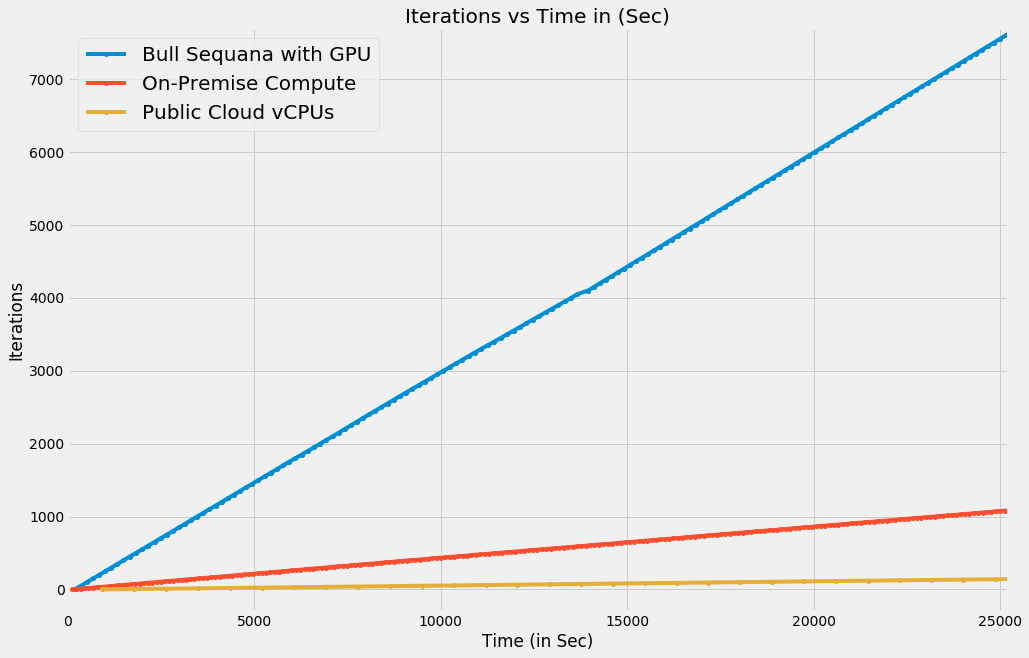

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from glob import glob

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

labels=['Bull Sequana with GPU', 'On-Premise Compute', 'Public Cloud vCPUs']


style_list = ['default', 'classic'] + sorted(
    style for style in plt.style.available if style != 'classic')
# Plot a demonstration figure for every available style sheet.
for style_label in pd.Series(style_list)[[7]]:
    with plt.style.context(style_label):
        
        plt.figure(figsize=(15, 10))
        for i, runtime_file in enumerate((
            #'test_dir_wave_1_GPU/runtime_wave.txt',
            #'test_dir_wave_32_CPU/runtime_wave.txt',
            #'test_dir_wave_1_CPU/runtime_wave.txt'
            'test_dir_starry_night_1_GPU/runtime_starry_night.txt', 
             'test_dir_starry_night_32_CPU/runtime_starry_night.txt', 
             'test_dir_starry_night_1_CPU/runtime_starry_night.txt'
            )):
            with open(runtime_file) as f:
                data = f.read().splitlines()
                useful_data = [line for line in data if 'Current Time' in line]
                structured_data = get_structured_data(useful_data)
                structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
                structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
                #structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations
                structured_data.set_index(range(len(structured_data)) * structured_data['Iteration'][0], inplace=True) #### seems to work

            plt.plot(structured_data['Time Elapsed'].cumsum(), structured_data.index,
                    marker='o', markersize=4, linestyle='-', label=labels[i])
        plt.legend(loc=2, prop={'size': 20})
        plt.xlabel('Time (in Sec)')
        plt.ylabel('Iterations')
        plt.title("Iterations vs Time in (Sec)")
        plt.xlim(0, 7 * 60 * 60)
        plt.ylim(-300, 7700)

(0, 25200)

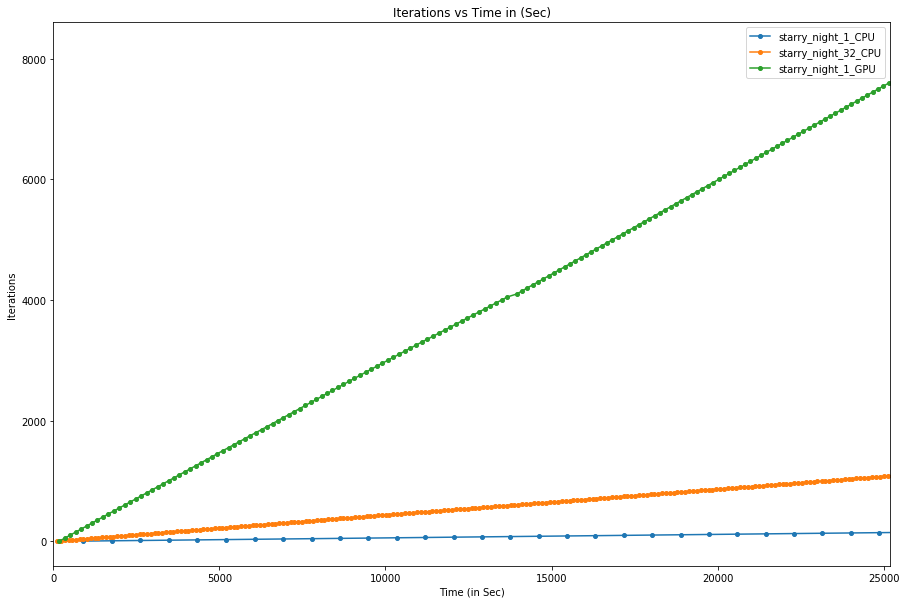

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from glob import glob

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

plt.figure(figsize=(15, 10))

for runtime_file in ('test_dir_starry_night_1_CPU/runtime_starry_night.txt', 
 'test_dir_starry_night_32_CPU/runtime_starry_night.txt', 
 'test_dir_starry_night_1_GPU/runtime_starry_night.txt'):
    with open(runtime_file) as f:
        data = f.read().splitlines()
        useful_data = [line for line in data if 'Current Time' in line]
        structured_data = get_structured_data(useful_data)
        structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
        structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
        #structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations
        structured_data.set_index(range(len(structured_data)) * structured_data['Iteration'][0], inplace=True) #### seems to work

    plt.plot(structured_data['Time Elapsed'].cumsum(), structured_data.index,
            marker='o', markersize=4, linestyle='-', label=runtime_file.split('/')[0].replace('test_dir_', ''))
plt.legend()
plt.xlabel('Time (in Sec)')
plt.ylabel('Iterations')
plt.title("Iterations vs Time in (Sec)")
plt.xlim(0, 7 * 60 * 60)

(0, 26000)

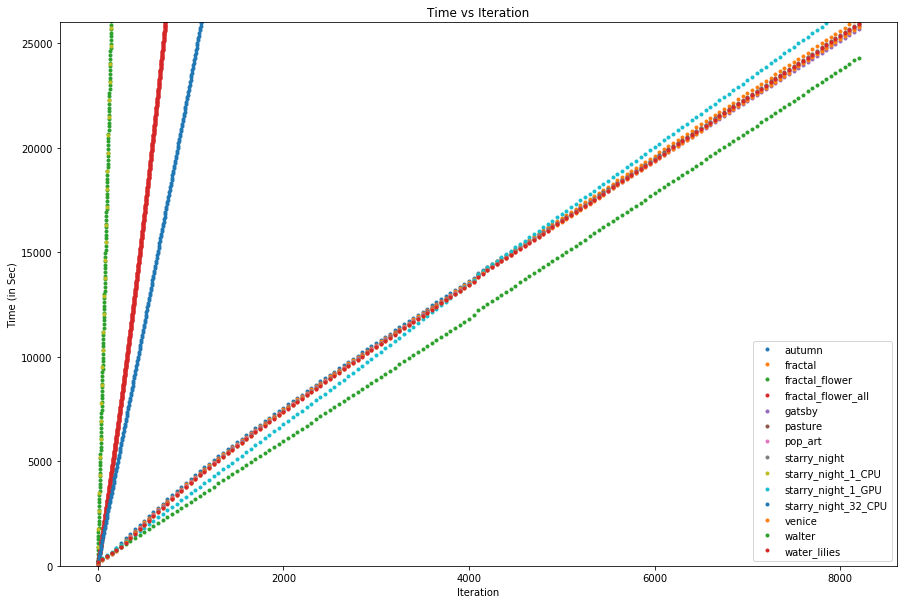

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from glob import glob

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

plt.figure(figsize=(15, 10))

for runtime_file in sorted(glob('test_dir_*/runtime_*')):
    with open(runtime_file) as f:
        data = f.read().splitlines()
        useful_data = [line for line in data if 'Current Time' in line]
        structured_data = get_structured_data(useful_data)
        structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
        structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
        #structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations
        structured_data.set_index(range(len(structured_data)) * structured_data['Iteration'][0], inplace=True) #### seems to work

    structured_data['Time Elapsed'].cumsum().plot(title="Time vs Iteration", 
        marker='o', ms=3, linestyle='None', label=runtime_file.split('/')[0].replace('test_dir_', ''))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Time (in Sec)')
plt.ylim(0, 26000)

(0, 26000)

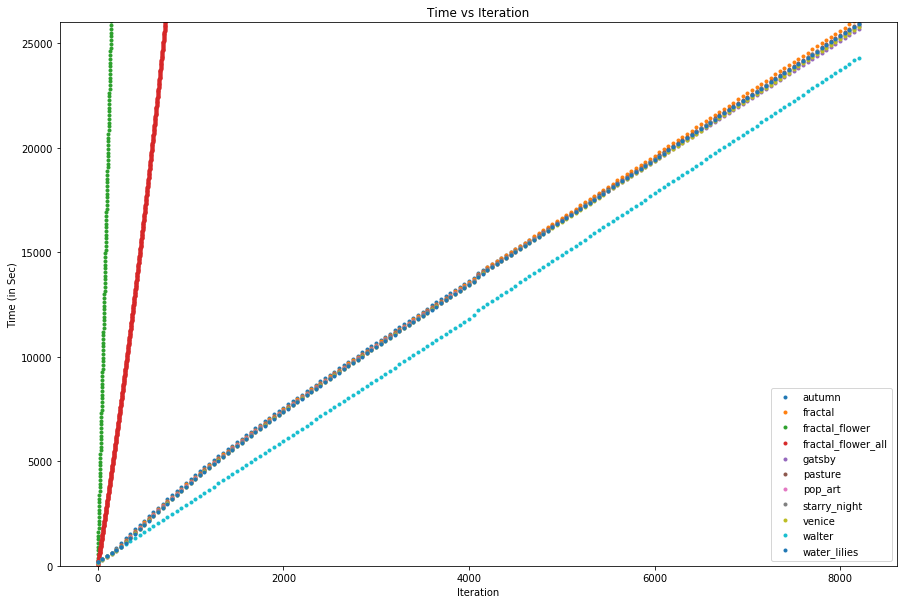

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from glob import glob

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

plt.figure(figsize=(15, 10))

for runtime_file in sorted(glob('test_dir_*/runtime_*')):
    with open(runtime_file) as f:
        data = f.read().splitlines()
        useful_data = [line for line in data if 'Current Time' in line]
        structured_data = get_structured_data(useful_data)
        structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
        structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
        #structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations
        structured_data.set_index(range(len(structured_data)) * structured_data['Iteration'][0], inplace=True) #### seems to work

    structured_data['Time Elapsed'].cumsum().plot(title="Time vs Iteration", 
        marker='o', ms=3, linestyle='None', label=runtime_file.split('/')[0].replace('test_dir_', ''))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Time (in Sec)')
plt.ylim(0, 26000)

In [ ]:
# Red (32 CPUs) and Green (1 CPU) are noticeably slower. Train for much fewer iterations.
# For CPUs, next time use 5 iterations instead of 1

In [ ]:
!time python evaluate.py --checkpoint test_dir_starry_night_1_CPU/checkpoint_starry_night/ --in-path ../building.JPG --out-path ../building_transformed.jpg
!time python evaluate.py --checkpoint test_dir_starry_night_32_CPU/checkpoint_starry_night/ --in-path ../building.JPG --out-path ../building_transformed.jpg
!time python evaluate.py --checkpoint test_dir_starry_night_1_GPU/checkpoint_starry_night/ --in-path ../building.JPG --out-path ../building_transformed.jpg

In [ ]:
!time python evaluate.py --checkpoint test_dir_starry_night_1_GPU/checkpoint_starry_night/ --in-path ../eiffel_tower.jpg  --out-path ../transformed.jpg